In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#%% importar o dataset

df = pd.read_csv('dataset.csv')

X = df.drop(['id', 'Severidade'], axis = 1)
y = df['Severidade']

In [4]:
#%% separar dados de treinamento e dados de teste

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [5]:
#%% padronizar os dados

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #media 0 e desvio padrão 1

X_train_sc = scaler.fit_transform(X_train)

X_test_sc = scaler.transform(X_test)

X_train_sc = pd.DataFrame(X_train_sc)
X_train_sc.columns = X_train.columns

X_test_sc = pd.DataFrame(X_test_sc)
X_test_sc.columns = X_train.columns


In [6]:
#%% seleção de features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

max_f = 20

lista_score = list()

for i in range(1, max_f +1):

  modelo_linear = LinearRegression()

  selector = RFE(modelo_linear, n_features_to_select = i, step = 1)

  selector = selector.fit(X_train_sc, y_train)

  mask = selector.support_

  features = X_train_sc.columns

  sel_features = features[mask]

  X_sel = X_train_sc[sel_features]

  score = cross_val_score(modelo_linear, X_sel, y_train, cv = 10, scoring = 'r2')

  print(np.mean(score))

  lista_score.append(np.mean(score))


-0.06445199150879911
0.09396486029263365
0.6727804225015419
0.726672062129073
0.8223245283790293
0.8233753596097613
0.8202942847768545
0.8160171069363862
0.8642534971610811
0.8655536026351045
0.8592050402770244
0.8626245070274547
0.8617649200609072
0.8568329558908353
0.85515608058196
0.8539354093341999
0.8498948606437716
0.8484410541107404
0.843880605104897
0.8417215821030458


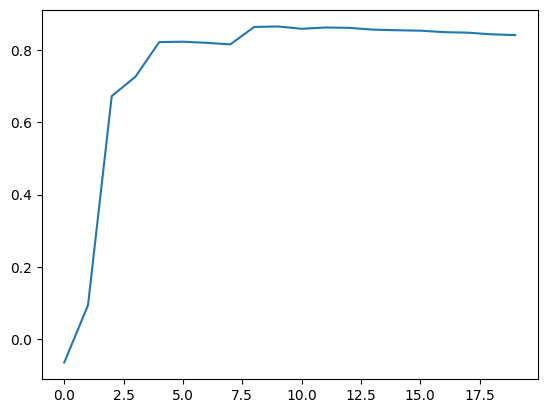

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lista_score)

plt.show()


In [8]:
#%% seleção de features Final
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


modelo_linear = LinearRegression()

selector = RFE(modelo_linear, n_features_to_select = 10, step = 1)

selector = selector.fit(X_train_sc, y_train)

mask = selector.support_

features = X_train_sc.columns

sel_features = features[mask]

X_sel = X_train_sc[sel_features]

score = cross_val_score(modelo_linear, X_sel, y_train, cv = 10, scoring = 'r2')

print(np.mean(score))
print(sel_features)


0.8655536026351045
Index(['NDVI_d28', 'SAVI_d28', 'NDVI_d01', 'SAVI_d01', 'NDVI_d04', 'SAVI_d04',
       'NDVI_d08', 'SAVI_d08', 'GNDVI_d08', 'SR_d08'],
      dtype='object')


In [9]:
#%% validação cruzada

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

modelo_linear = LinearRegression()

score = cross_val_score(modelo_linear, X_sel, y_train, cv = 10, scoring = 'r2')

print(np.mean(score))



0.8655536026351045


Irei testar alguns modelos diferentes com o intuito de melhorar a acurácia de nosso algoritmo para a resolução do problema.

Iei utilizar um dataframe chamado 'df_score' para guardar a média da validação cruzada, para que no final possamos analizar e escolher qual algoritmo performou melhor

In [165]:
scores = {'linear_regression': np.mean(score), 'svr': 0, 'random_forest': 0, 'knn': 0, 'adaboost': 0, 'gbm': 0,}
print(scores)

{'linear_regression': 0.8488346695363568, 'svr': 0, 'random_forest': 0, 'knn': 0, 'adaboost': 0, 'gbm': 0}


SVC para regreção (SVR)

In [167]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint, loguniform

In [17]:
modelo_svr = SVR()

In [173]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

In [174]:
grid_search_svr = GridSearchCV(
    estimator=modelo_svr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Usando erro quadrático médio negativo para otimizar
    cv=10,  # 10-fold cross-validation
    n_jobs=-1,  # Usar todos os núcleos do processador
    verbose=3  # Para exibir informações durante a busca
)

In [175]:
grid_search_svr.fit(X_sel, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


GridSearchCV(cv=10, estimator=SVR(C=35.75316131724075, gamma='auto'), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=3)

In [176]:
best_params_svr = grid_search_svr.best_params_
best_model_svr = grid_search_svr.best_estimator_

print("Melhores hiperparâmetros:", best_params_svr)

Melhores hiperparâmetros: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


In [177]:
modelo_svr = SVR(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'])

In [178]:
modelo_svr.fit(X_sel, y_train)

SVR(C=35.75316131724075, gamma='auto')

In [180]:
score = cross_val_score(modelo_svr, X_sel, y_train, cv = 10, scoring = 'r2')
scores['svr'] = np.mean(score)
print(np.mean(score))

0.8726516804084816


Random Forest para Regressão

In [166]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [188]:
modelo_rf = RandomForestRegressor(random_state=42)

In [190]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [191]:
grid_search_rf = GridSearchCV(
    estimator=modelo_rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
    verbose=3
)

In [192]:
grid_search_rf.fit(X_sel, y_train)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
810 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
383 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=3)

In [193]:
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

print("Melhores hiperparâmetros:", best_params_rf)

Melhores hiperparâmetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [195]:
modelo_rf = RandomForestRegressor(n_estimators=best_params_rf['n_estimators'], max_depth=best_params_rf['max_depth'], max_features=best_params_rf['max_features'], min_samples_split=best_params_rf['min_samples_split'] )
modelo_rf.fit(X_sel, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt')

In [204]:
score = cross_val_score(modelo_rf, X_sel, y_train, cv = 10, scoring = 'r2')
scores['random_forest'] = np.mean(score)
print(np.mean(score))

0.8469903527426599


KNN

In [119]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [197]:
grid={'n_neighbors':np.arange(1,40)}

In [203]:
grid_search_knn = GridSearchCV(KNeighborsRegressor(),grid,cv=10)
grid_search_knn.fit(X_sel, y_train)
print("Best parameters of Logistic Regression :",grid_search_knn.best_params_)

Best parameters of Logistic Regression : {'n_neighbors': 3}


In [199]:
modelo_knn = KNeighborsRegressor(n_neighbors=logreg_cv.best_params_['n_neighbors'])

In [200]:
modelo_knn.fit(X_sel, y_train)

KNeighborsRegressor(n_neighbors=3)

In [205]:
score = cross_val_score(modelo_knn, X_sel, y_train, cv = 10, scoring = 'r2')
scores['knn'] = np.mean(score)
print(np.mean(score))

0.90458494597154


AdaBoost

In [130]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [140]:
modelo_adaboost = AdaBoostRegressor(random_state=42)


In [141]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential']
}


In [142]:
grid_search_adaboost = GridSearchCV(
    estimator=modelo_adaboost,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
    verbose=3
)

In [143]:
grid_search_adaboost.fit(X_sel, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=10, estimator=AdaBoostRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 1.0],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=3)

In [144]:
best_params_adaboost = grid_search_adaboost.best_params_
best_model_adaboost = grid_search_adaboost.best_estimator_

print("Melhores hiperparâmetros:", best_params_adaboost)

Melhores hiperparâmetros: {'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 200}


In [147]:
modelo_adaboost = AdaBoostRegressor(learning_rate=best_params_adaboost['learning_rate'], loss = best_params_adaboost['loss'], n_estimators = best_params_adaboost['n_estimators'] ,random_state=42)

In [206]:
score = cross_val_score(modelo_adaboost, X_sel, y_train, cv = 10, scoring = 'r2')
scores['adaboost'] = np.mean(score)
print(np.mean(score))

0.8485842361018546


Gradient Boosting Machines (GBM)

In [149]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [156]:
modelo_gbm = GradientBoostingRegressor(random_state=42)

In [157]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [158]:
grid_search_gbm = GridSearchCV(
    estimator=modelo_gbm,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
    verbose=3
)

In [159]:
grid_search_gbm.fit(X_sel, y_train)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=3)

In [161]:
best_params_gbm = grid_search_gbm.best_params_
best_model_gbm = grid_search_gbm.best_estimator_

print("Melhores hiperparâmetros:", best_params_gbm)

Melhores hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


In [162]:
modelo_gbm = GradientBoostingRegressor(
    n_estimators=best_params_gbm['n_estimators'],
    learning_rate=best_params_gbm['learning_rate'],
    max_depth=best_params_gbm['max_depth'],
    min_samples_split=best_params_gbm['min_samples_split'],
    min_samples_leaf=best_params_gbm['min_samples_leaf'],
    random_state=42
)

In [163]:
modelo_gbm.fit(X_sel, y_train)

GradientBoostingRegressor(max_depth=7, min_samples_leaf=4, min_samples_split=10,
                          n_estimators=50, random_state=42)

In [207]:
score = cross_val_score(modelo_gbm, X_sel, y_train, cv = 10, scoring = 'r2')
scores['gbm'] = np.mean(score)
print(np.mean(score))

0.8488346695363568


Analizando os desempenhos dos algoritmos

In [222]:
df_scores = pd.DataFrame.from_dict({'Algoritmos': scores.keys(), 'Score': scores.values()})

In [209]:
import matplotlib.pyplot as plt
import numpy as np

<BarContainer object of 6 artists>

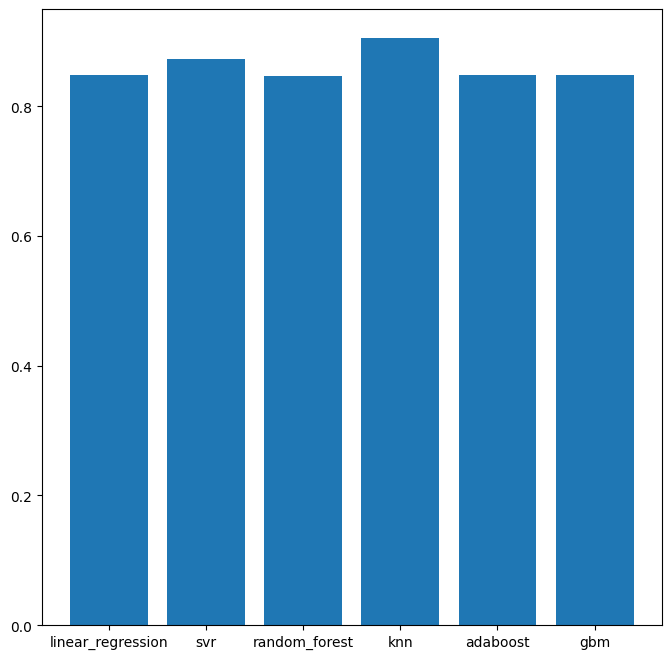

In [226]:
plt.figure(figsize=(8, 8))
plt.bar(df_scores['Algoritmos'], df_scores['Score'])

Como podemos observar o KNN foi o que obteve um melhor desempenho, então irei utiliza-lo

In [232]:
#%% testar nos dados de teste

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred = modelo_knn.predict(X_test_sc[sel_features])

r2 = modelo_knn.score(X_test_sc[sel_features], y_test)

rmse = (mean_squared_error(y_test, y_pred)**0.5)

mae = mean_absolute_error(y_test, y_pred)

r2_knn = r2

print('r2', r2)
print('rmse', rmse)
print('mae', mae)


r2 0.9109711157391922
rmse 6.711038171053221
mae 5.185308641975308


Trecho fornecido pelo professor

In [228]:
#%% modelo final - Regressão linear multipla

modelo_linear = LinearRegression()

modelo_linear.fit(X_sel, y_train)

LinearRegression()

In [230]:
#%% testar nos dados de teste

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred = modelo_linear.predict(X_test_sc[sel_features])

r2 = modelo_linear.score(X_test_sc[sel_features], y_test)

rmse = (mean_squared_error(y_test, y_pred)**0.5)

mae = mean_absolute_error(y_test, y_pred)

r2_linear = r2

print('r2', r2)
print('rmse', rmse)
print('mae', mae)

r2 0.887634277870405
rmse 7.539476072278346
mae 6.344066348950323


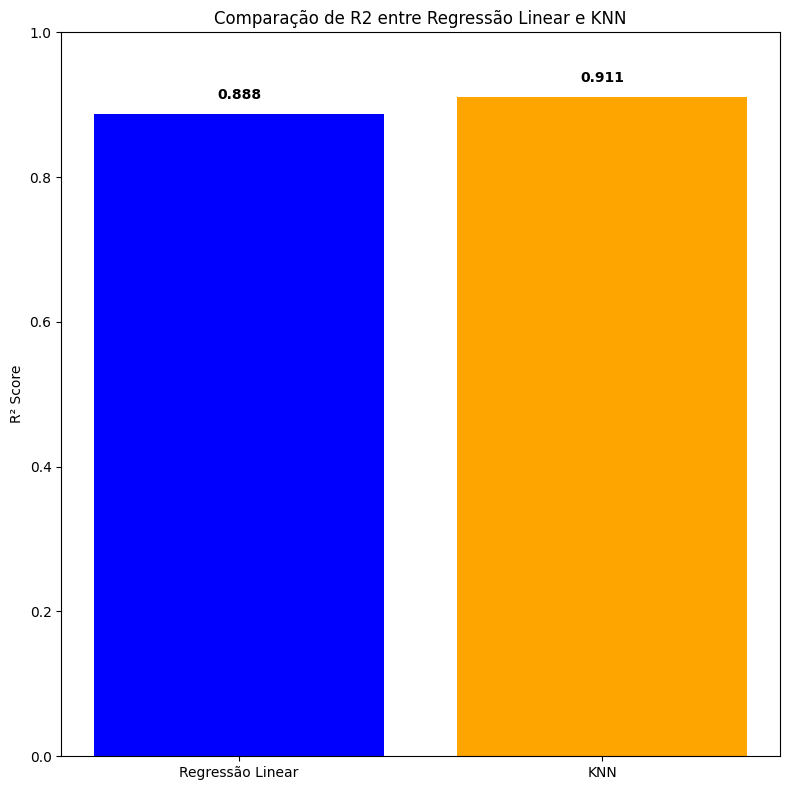

In [234]:
models = ['Regressão Linear', 'KNN']
r2_scores = [r2_linear, r2_knn]


plt.figure(figsize=(8, 8))
plt.bar(models, r2_scores, color=['blue', 'orange'])


plt.ylabel('R² Score')
plt.title('Comparação de R2 entre Regressão Linear e KNN')
plt.ylim([0, 1])

for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, str(round(v, 3)), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Como podemos observar o KNN teve uma pequena melhora em comparação com a regreção linear proposta inicialmente